In [1]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
import seaborn as sns
import numpy as np

from metadata.etfs import etfs_large, etfs_small
from utils.conn_data import load_pickle

plt.style.use('ggplot')

In [2]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
results_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs", "results")

des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods_tags = {}
# fs_methods_tags = {
#     "lasso1_nocluster": "Lasso",
#     "pairwise-granger_nocluster": "Pairwise Granger",
#     "multivariate-granger_nocluster": "Multivariate Granger",
#     "dynotears_rollingcluster_k5": "Dynotears",
#     "var-lingam_rollingcluster_k5": "VAR-LiNGAM",

# }

lasso_methods = [
    "lasso1_nocluster", 
    "lasso1_rollingkmeans_k5_pca", "lasso1_rollingspectral_k5_pca",
    "lasso1_rollingkmeans_k5_rank", "lasso1_rollingspectral_k5_rank",
    "lasso1_rollingkmeans_k10_pca", "lasso1_rollingspectral_k10_pca",
    "lasso1_rollingkmeans_k10_rank", "lasso1_rollingspectral_k10_rank",
    "lasso1_rollingkmeans_kauto_eigen_rank", "lasso1_rollingspectral_kauto_eigen_rank"

]
varlingam_methods = [
    "var-lingam_rollingkmeans_k5_pca", "var-lingam_rollingspectral_k5_pca",
    "var-lingam_rollingkmeans_k5_rank", "var-lingam_rollingspectral_k5_rank",
    "var-lingam_rollingkmeans_k10_pca", "var-lingam_rollingspectral_k10_pca",
    "var-lingam_rollingkmeans_k10_rank", "var-lingam_rollingspectral_k10_rank",
    "var-lingam_rollingspectral_kauto_eigen_rank", "var-lingam_rollingkmeans_kauto_eigen_rank"
]
pairwisegranger_methods = [
    "pairwise-granger_rollingkmeans_k5_pca", "pairwise-granger_rollingspectral_k5_pca",
    "pairwise-granger_rollingkmeans_k5_rank", "pairwise-granger_rollingspectral_k5_rank",
    "pairwise-granger_rollingkmeans_k10_pca", "pairwise-granger_rollingspectral_k10_pca",
    "pairwise-granger_rollingkmeans_k10_rank", "pairwise-granger_rollingspectral_k10_rank",
    "pairwise-granger_rollingspectral_kauto_eigen_rank", "pairwise-granger_rollingkmeans_kauto_eigen_rank"
]
mulivariategranger_methods = [
    "multivariate-granger_rollingkmeans_k5_pca", "multivariate-granger_rollingspectral_k5_pca",
    "multivariate-granger_rollingkmeans_k5_rank", "multivariate-granger_rollingspectral_k5_rank",
    "multivariate-granger_rollingkmeans_k10_pca", "multivariate-granger_rollingspectral_k10_pca",
    "multivariate-granger_rollingkmeans_k10_rank", "multivariate-granger_rollingspectral_k10_rank",
    "multivariate-granger_rollingspectral_kauto_eigen_rank", "multivariate-granger_rollingkmeans_kauto_eigen_rank"
]
dynotears_methods = [
        "dynotears_rollingkmeans_k5_pca", "dynotears_rollingspectral_k5_pca", 
        "dynotears_rollingkmeans_k5_rank", "dynotears_rollingspectral_k5_rank",
        "dynotears_rollingkmeans_k10_pca", "dynotears_rollingspectral_k10_pca", 
        "dynotears_rollingkmeans_k10_rank", "dynotears_rollingspectral_k10_rank",
        "dynotears_rollingspectral_kauto_eigen_rank",
]

fs_methods = lasso_methods

fs_methods = [
    "sfstscv_nocluster", 
    # "sfstscv_rollingkmeans_k5_pca", "sfstscv_rollingkmeans_k5_rank",
    # "sfstscv_rollingkmeans_k10_pca", "sfstscv_rollingkmeans_k10_rank",
    # "sfstscv_rollingkmeans_kauto_eigen_rank",
    "dynotears_nocluster", 
    # "dynotears_rollingkmeans_k5_pca", "dynotears_rollingkmeans_k5_rank",
    # "dynotears_rollingkmeans_k10_pca", "dynotears_rollingkmeans_k10_rank",
    # "var-lingam_rollingkmeans_k5_pca", "var-lingam_rollingkmeans_k5_rank",
    # "var-lingam_rollingkmeans_k10_pca", "var-lingam_rollingkmeans_k10_rank",
    # "multivariate-granger_rollingkmeans_k5_pca", "multivariate-granger_rollingkmeans_k5_rank",
    # "multivariate-granger_rollingkmeans_k10_pca", "multivariate-granger_rollingkmeans_k10_rank",
    # "pairwise-granger_nocluster",
    # "pairwise-granger_rollingkmeans_k5_pca", "pairwise-granger_rollingkmeans_k5_rank",
    # "pairwise-granger_rollingkmeans_k10_pca", "pairwise-granger_rollingkmeans_k10_rank"
    ]

metric_names = ["mse", "mae", "mse_crisis", "mae_crisis"] # ["stability", "mse", "mae", "mse_crisis", "mae_crisis"]
etf_focus = None
stability_threshold = 0.8   
plot_ts = False

In [3]:
warnings.simplefilter("ignore")


all_metrics = []
all_rolling_metrics = []
all_stability = []
all_parents = []
for fs in fs_methods:

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        if (etf_focus != etf) and (etf_focus is not None):
            continue
        else:
            pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions']

        # filter predictions
        predictions_df.loc[(predictions_df['prediction_zscore'] == 1)|(predictions_df['prediction_zscore'] == -1), 'prediction_zscore'] = 0
        predictions_df.loc[(predictions_df['prediction'] == 1)|(predictions_df['prediction'] == -1), 'prediction'] = 0

        predictions_gfc_df = predictions_df.loc["2007-07-01":"2008-11-01"]
        predictions_dj_flash_crash_df = predictions_df.loc["2010-03-01":"2010-07-01"]
        predictions_tsunami_fukushima_df = predictions_df.loc["2011-01-01":"2011-05-01"]
        predictions_black_monday_df = predictions_df.loc["2011-06-01":"2011-10-01"]
        predictions_chinese_black_monday_df = predictions_df.loc["2015-06-01":"2015-10-01"]
        predictions_dj_plunge_df = predictions_df.loc["2018-01-01":"2018-05-01"]
        predictions_covid_df = predictions_df.loc["2020-01-01":"2020-05-01"]

        crisis_predictions = [
            predictions_gfc_df, predictions_dj_flash_crash_df, predictions_tsunami_fukushima_df, 
            predictions_black_monday_df, predictions_chinese_black_monday_df, predictions_dj_plunge_df, predictions_covid_df
            ]

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["true"] - rolling_metric_df["prediction"]

        # rolling mse
        rolling_metric_df["rolling_var"] = rolling_metric_df["prediction"].rolling(12).var()
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["true"] - rolling_metric_df["prediction"]).pow(2).rolling(12).mean()
        rolling_metric_df["rolling_mse"] = rolling_metric_df["rolling_var"] + rolling_metric_df["rolling_bias"] * 100
        rolling_metric_df["rolling_var"] = (rolling_metric_df["rolling_var"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["rolling_bias"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df = rolling_metric_df[["diff", "rolling_mse", "rolling_var", "rolling_bias"]]

        # add info
        rolling_metric_df["fs"] = fs_methods_tags[fs] if len(fs_methods_tags) > 0 else fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"]) * 100
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"]) * 100

        crisis_predictions_df = pd.concat(crisis_predictions)
        crisis_mse = mean_squared_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"]) * 100
        crisis_mae = mean_absolute_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"]) * 100

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]

        # save parents
        parents_of_target_df["fs"] = fs_methods_tags[fs] if len(fs_methods_tags) > 0 else fs
        parents_of_target_df["etf"] = etf
        
        tot = len(parents_of_target_df["date"].unique())
        stability_df = (parents_of_target_df.fillna(0).groupby(["cluster"]).sum()[["value"]] / tot).sort_values(by="value", ascending=False)
        stability_df = pd.concat({etf: stability_df}, names=['etf'])
        stability.append(stability_df)

        stability_measure = (stability_df).sum().iloc[0] / stability_df.shape[0]
        metrics_df = pd.DataFrame({
            "fs": fs_methods_tags[fs] if len(fs_methods_tags) > 0 else fs, 
            "etf": etf, 
            "mse": [mse],
            "mae": [mae], 
            # "bias": [bias],
            # "var": [var],
            "mse_crisis": [crisis_mse], 
            "mae_crisis": [crisis_mae],
            "stability": stability_measure})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
        all_parents.append(parents_of_target_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
    all_stability.append(pd.concat(stability))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
all_parents_df = pd.concat(all_parents)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

## Boxplots with summary statistics

In [4]:
melted_all_metrics_df

,fs,etf,variable,value
0,sfstscv_nocluster,XLE,mse,2.014214
1,sfstscv_nocluster,XLK,mse,3.079305
2,sfstscv_nocluster,XLF,mse,1.888717
3,sfstscv_nocluster,SPY,mse,1.433789
4,sfstscv_nocluster,XLY,mse,1.133138
...,...,...,...,...
90,dynotears_nocluster,XLY,stability,4.233480
91,dynotears_nocluster,XLU,stability,6.907489
92,dynotears_nocluster,XLB,stability,4.634361
93,dynotears_nocluster,XLV,stability,4.354626


In [6]:
melted_all_metrics_df["variable"].unique()

array(['mse', 'mae', 'mse_crisis', 'mae_crisis', 'stability'],
      dtype=object)

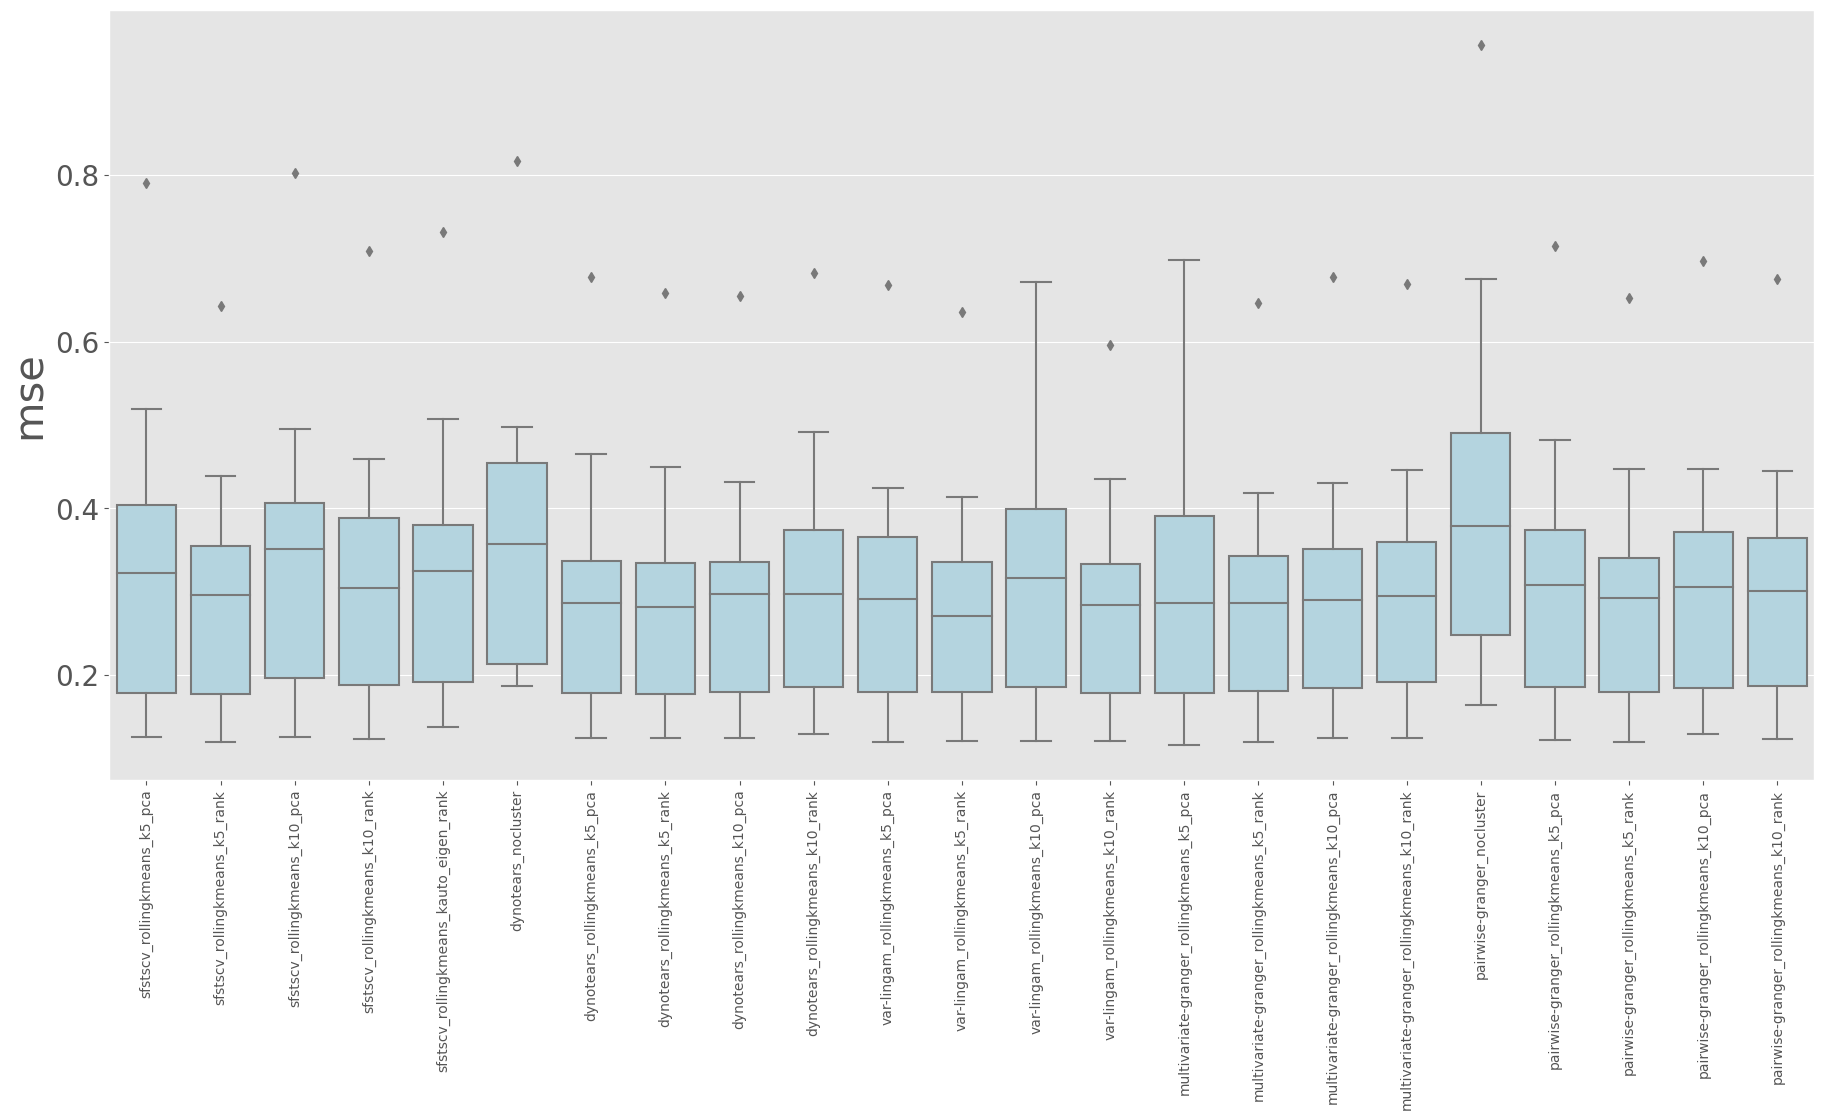

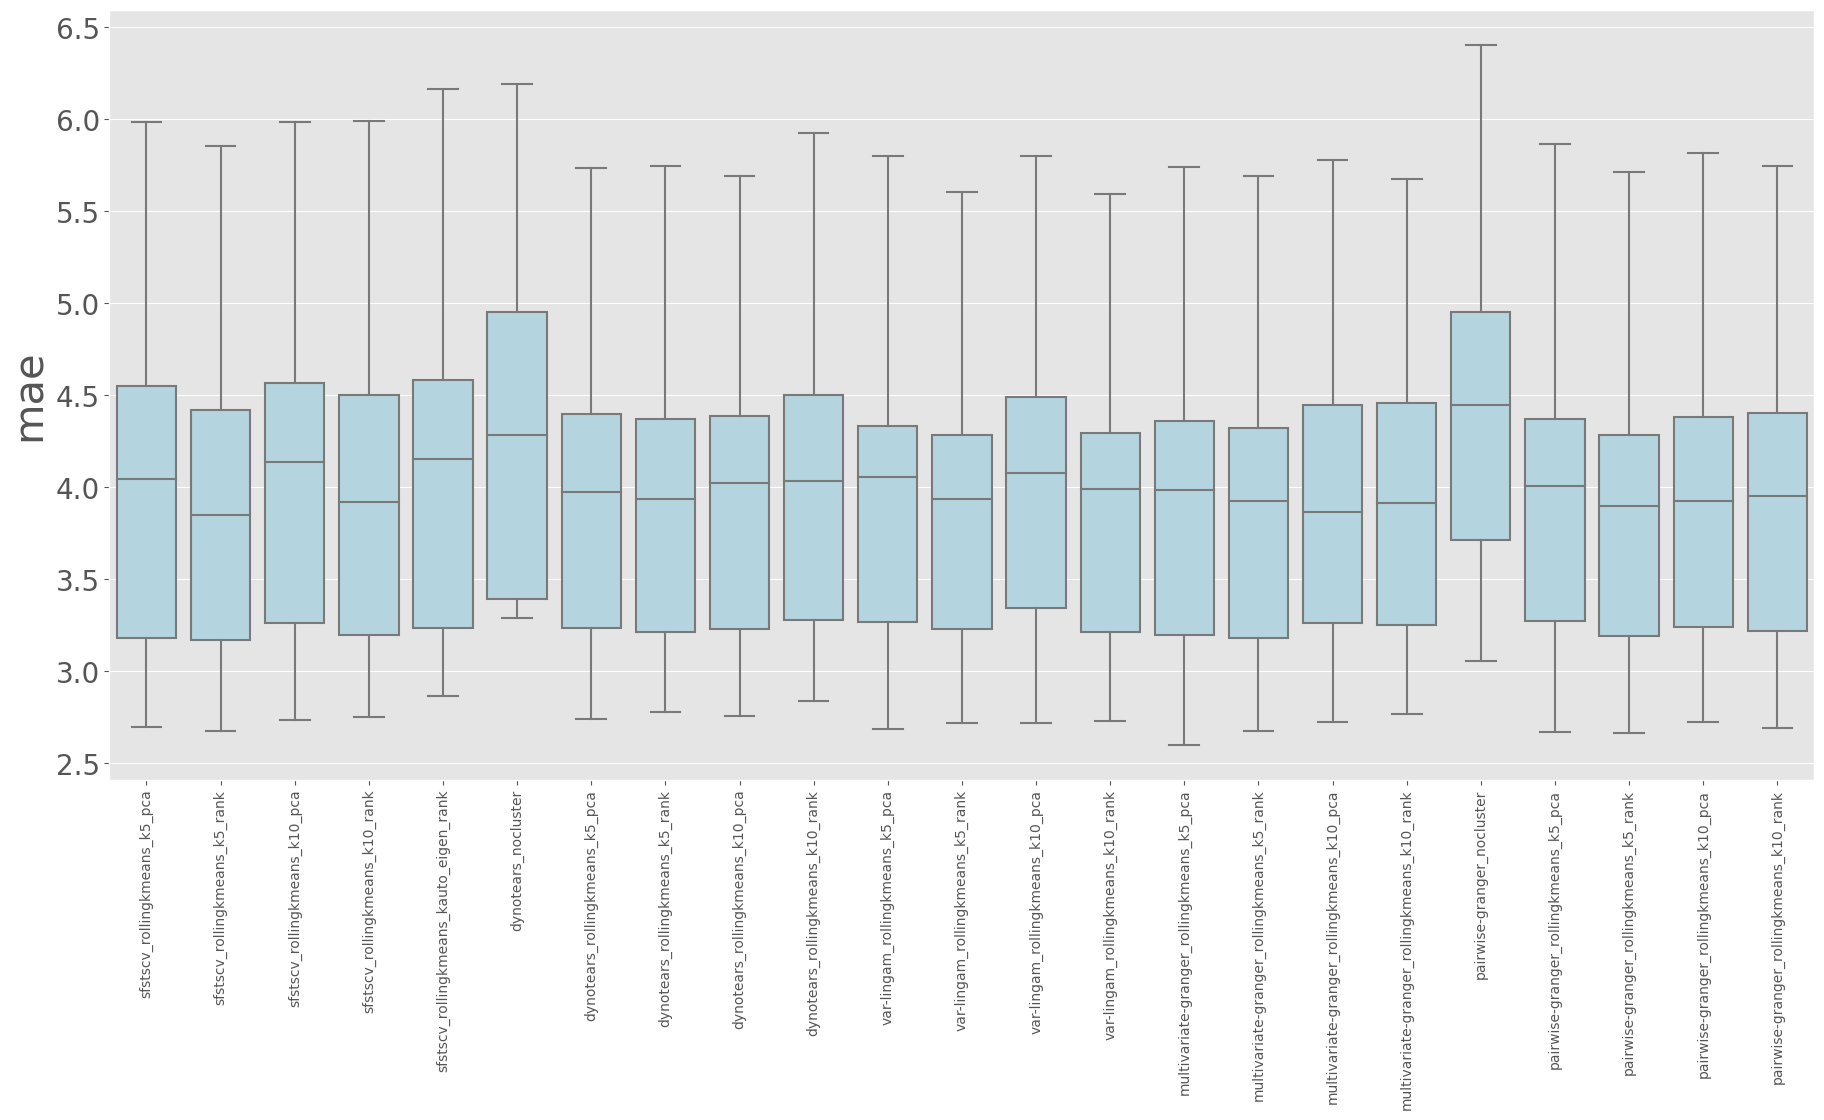

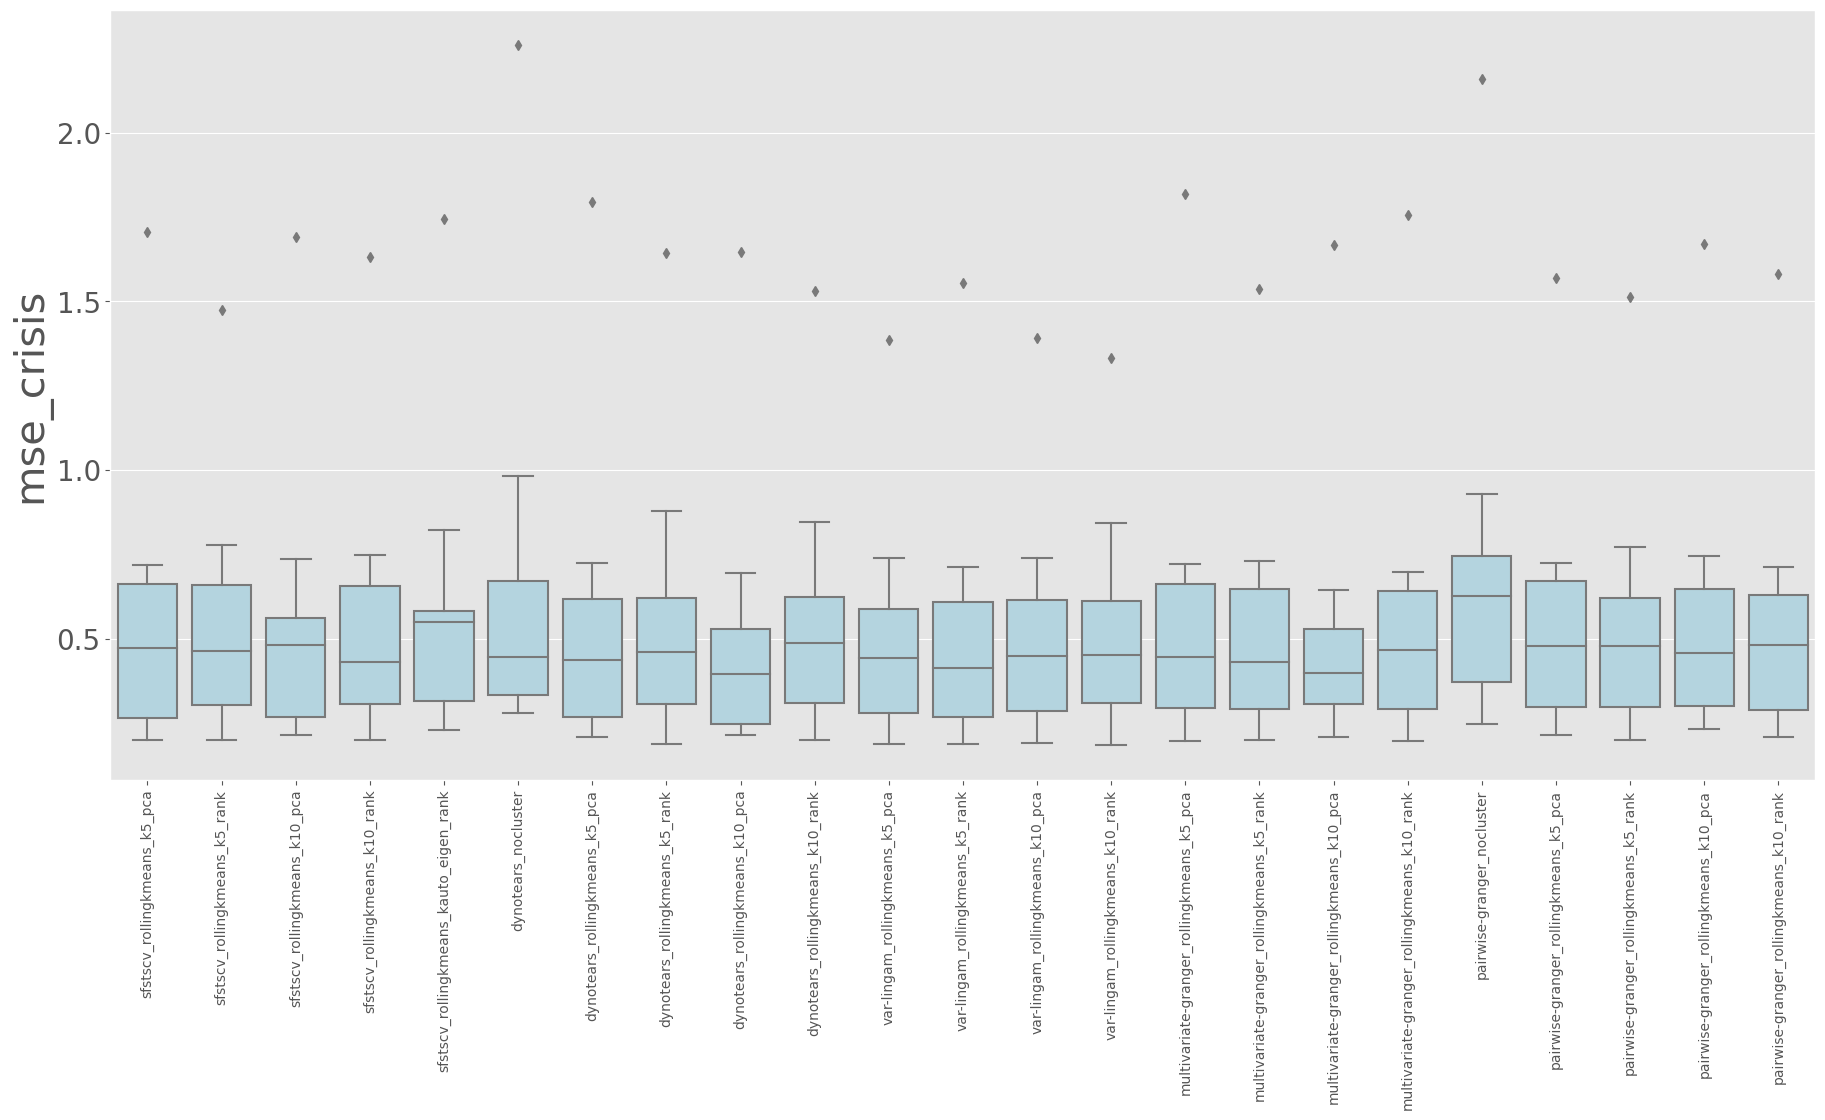

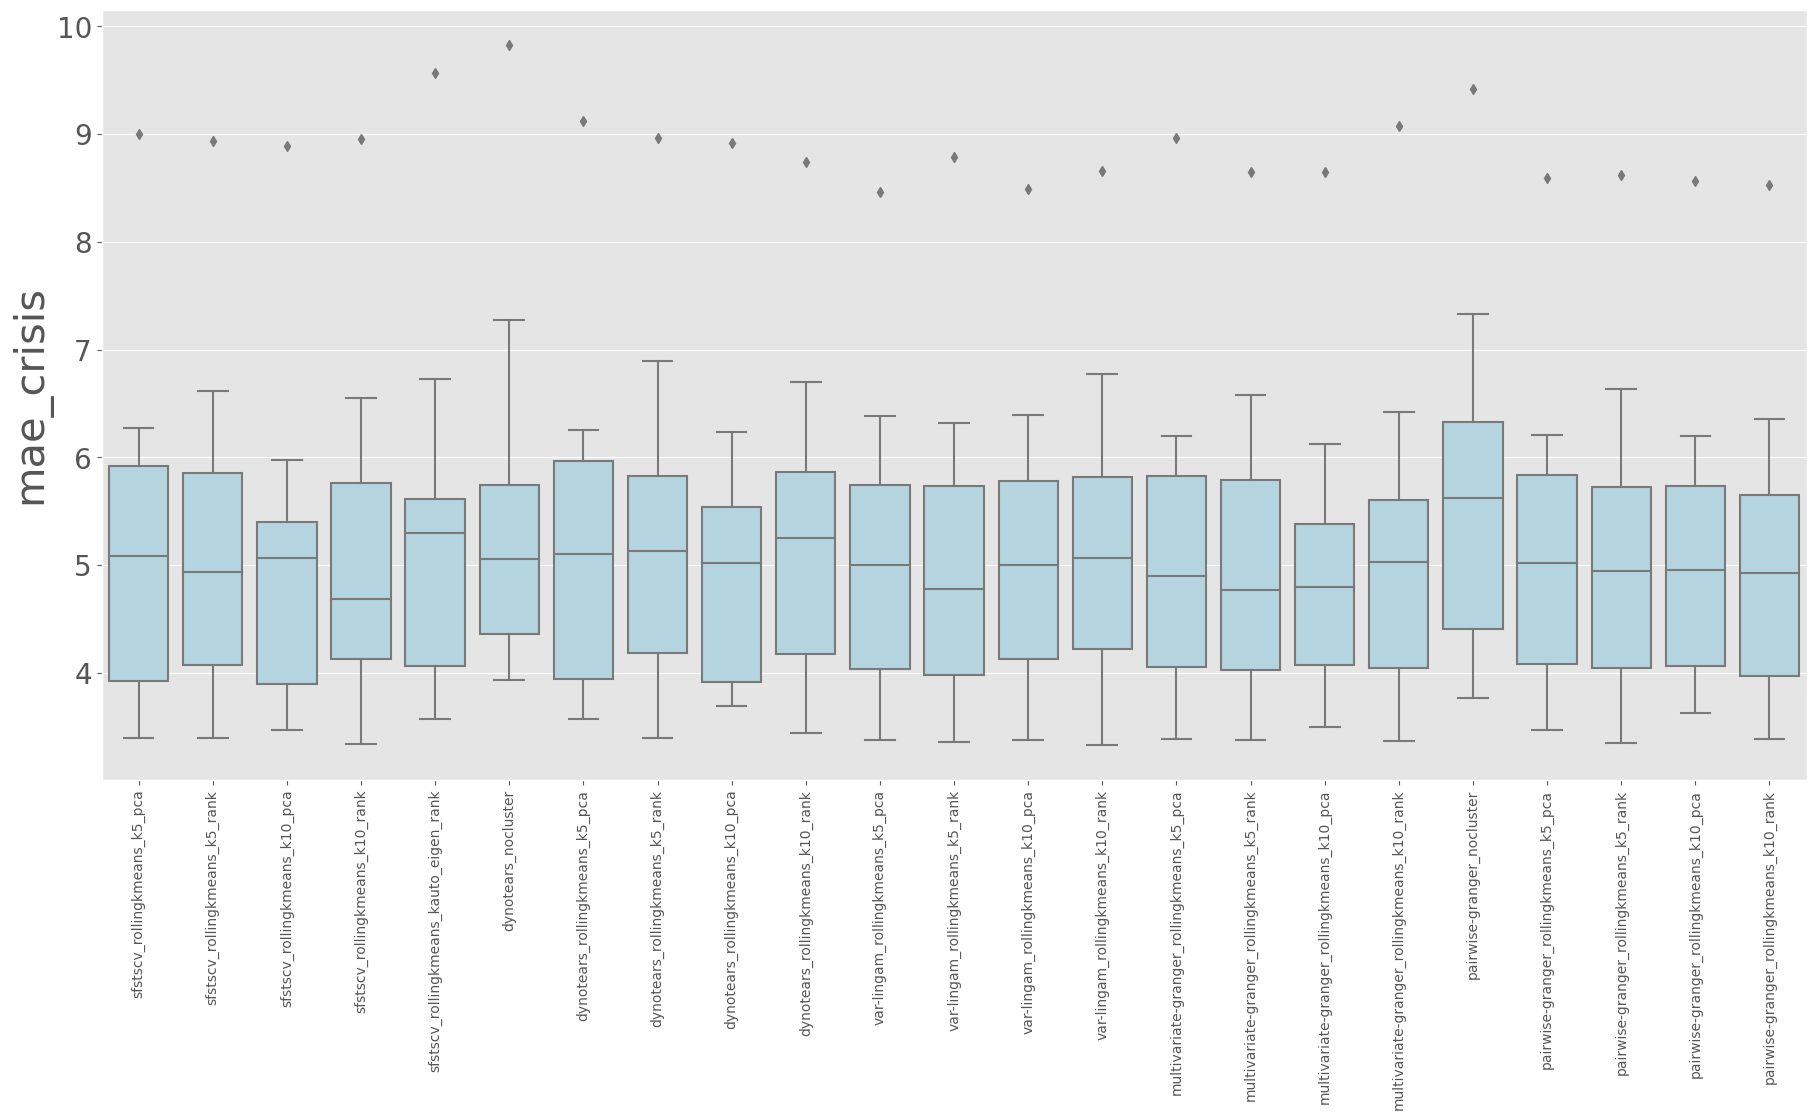

In [16]:
for m in metric_names:
    boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=30)
    ax.set_xlabel("", fontsize=20)
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=20)
    # ax.legend(loc="best",fontsize=10)
    plt.xticks(rotation=90)
    fig.savefig(os.path.join(results_path, f'boxplot_agg_{m}_fs.png'))

## Prediction error over time

### (a) Bias-Variance Trade-off

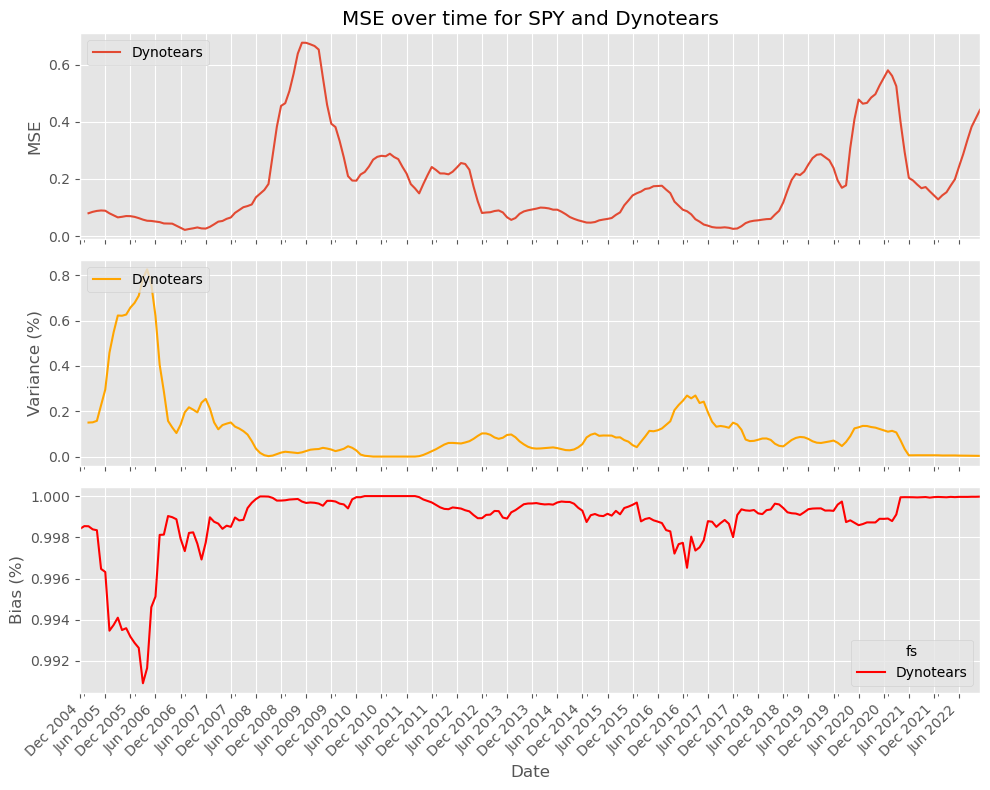

In [7]:
etf = "SPY"
fs = "Dynotears"

# mse
etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
etf_rolling_metrics_df["diff_lasso_var-lingam"] = 1

# variance
etf_rolling_variance_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_var")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel()
etf_rolling_variance_df = etf_rolling_variance_df.rolling(3).mean()
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel(1) 

# bias
etf_rolling_bias_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_bias")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel()
etf_rolling_biass_df = etf_rolling_bias_df.rolling(3).mean()
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel(1) 

# plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# plotting on the upper subplot
etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
axs[0].set_title(f'MSE over time for {etf} and {fs}')
axs[0].set_ylabel('MSE')
axs[0].legend(loc='upper left')

# plotting on the upper subplot
etf_rolling_variance_df.plot(ax=axs[1], color="orange")
# axs[1].set_title(f'Variance over time for {etf}')
axs[1].set_ylabel('Variance (%)')
axs[1].legend(loc='upper left')

# plotting on the lower subplot
etf_rolling_bias_df.plot(ax=axs[2], color="red")
# axs[2].set_title(f'Bias over time for {etf}')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Bias (%)')

# adding months and years to the index of the plot
tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
axs[2].set_xticks(tick_positions)
axs[2].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

# adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

### (b) Rolling MSE

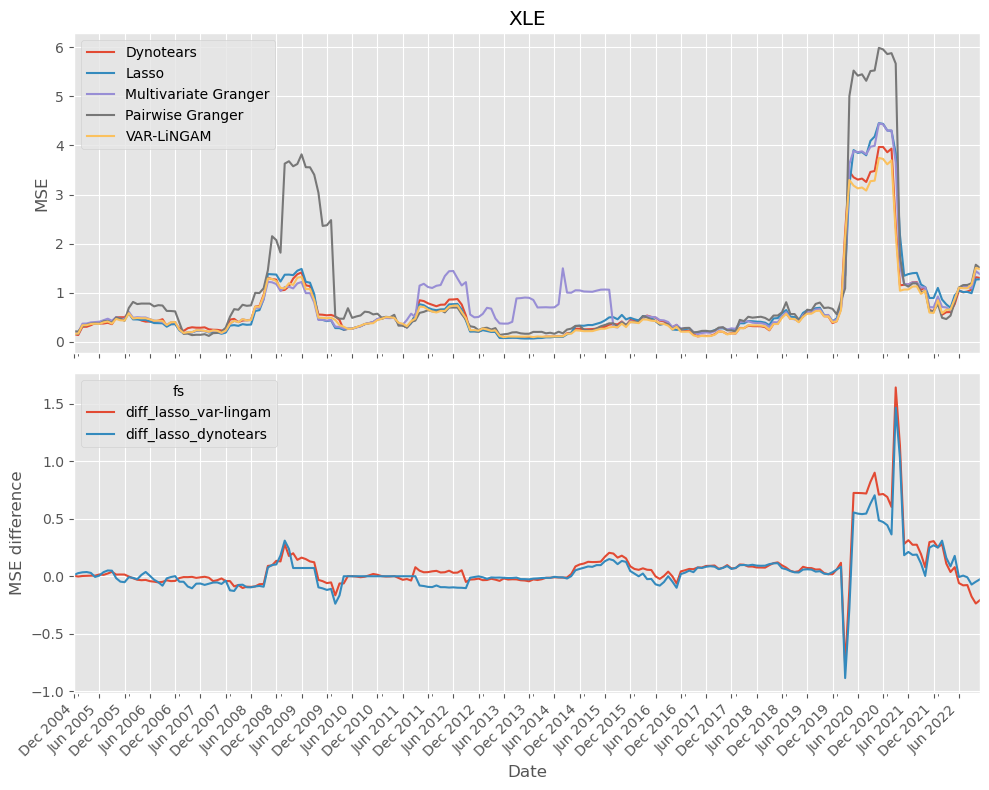

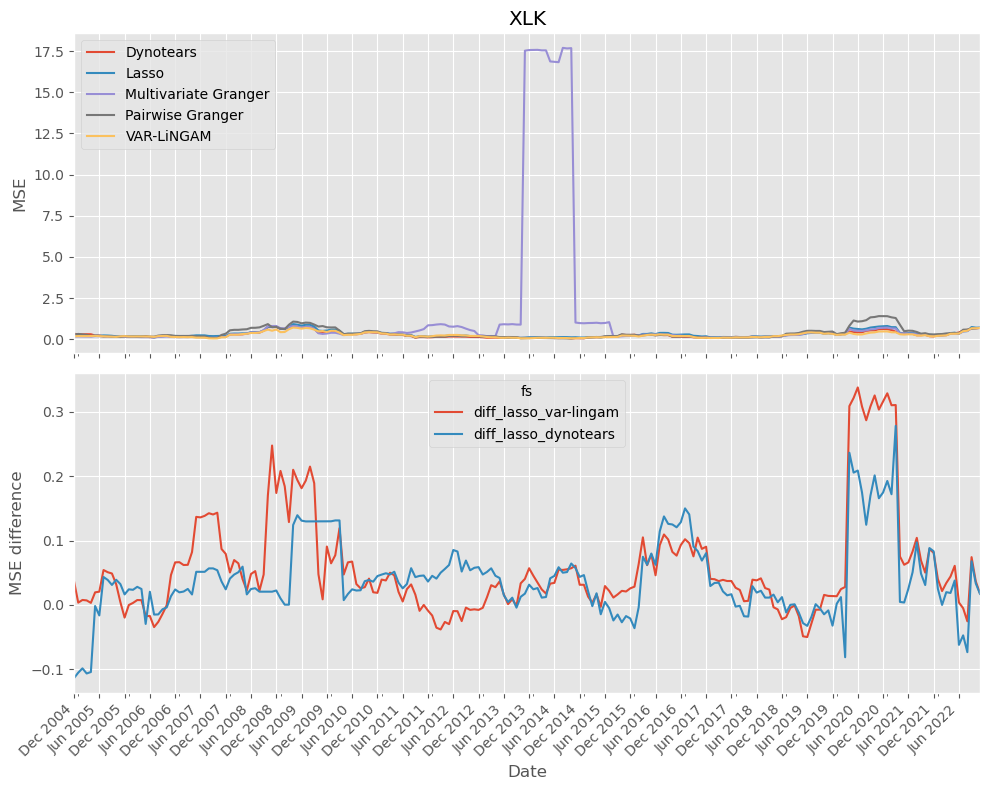

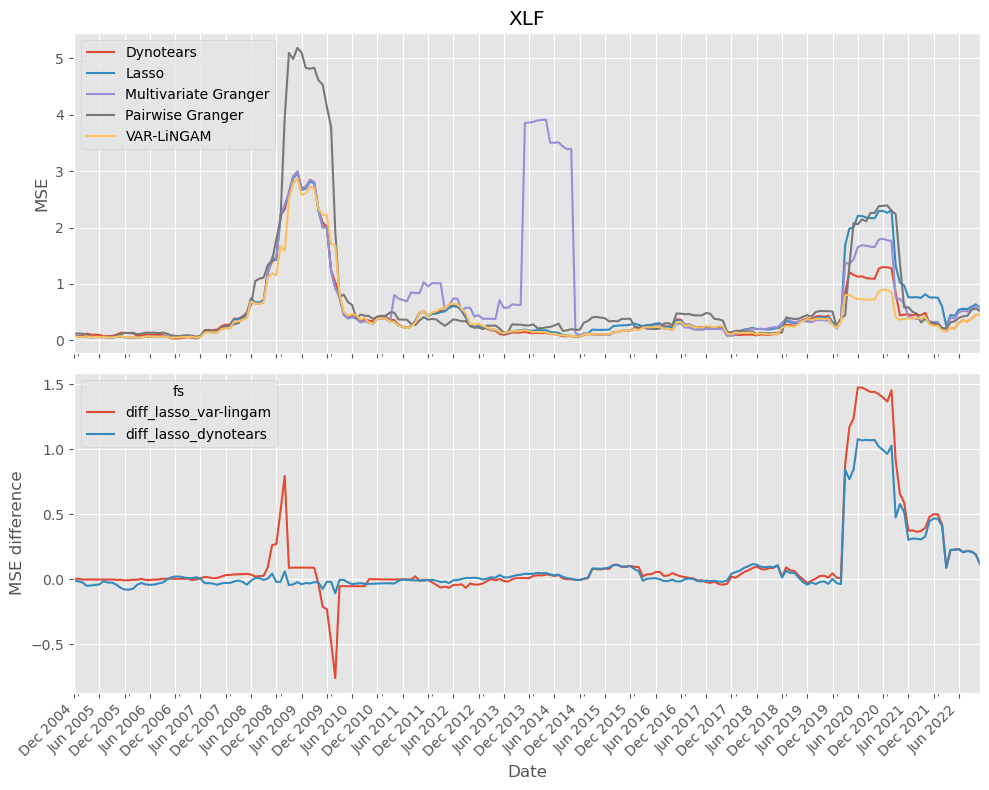

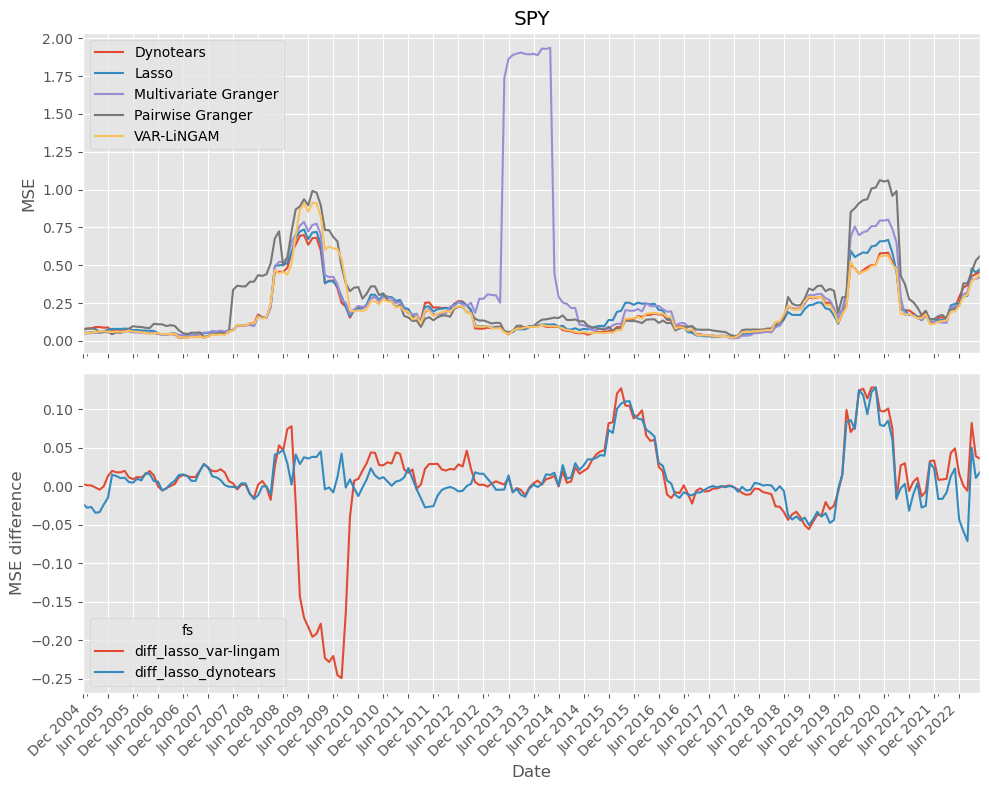

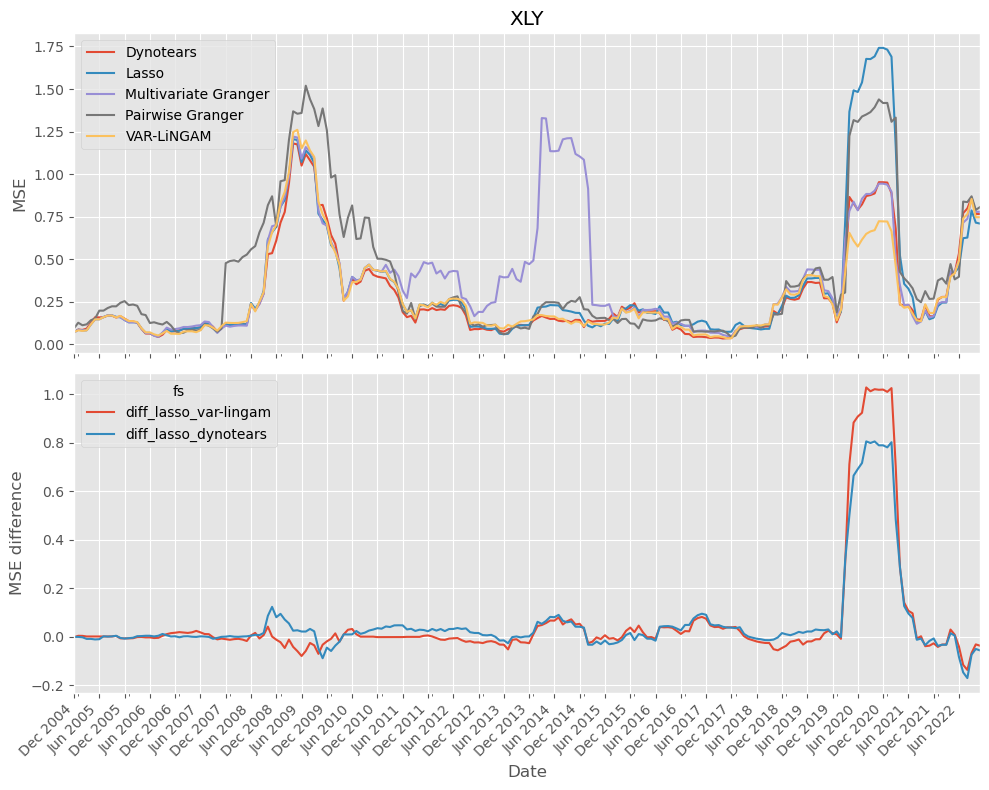

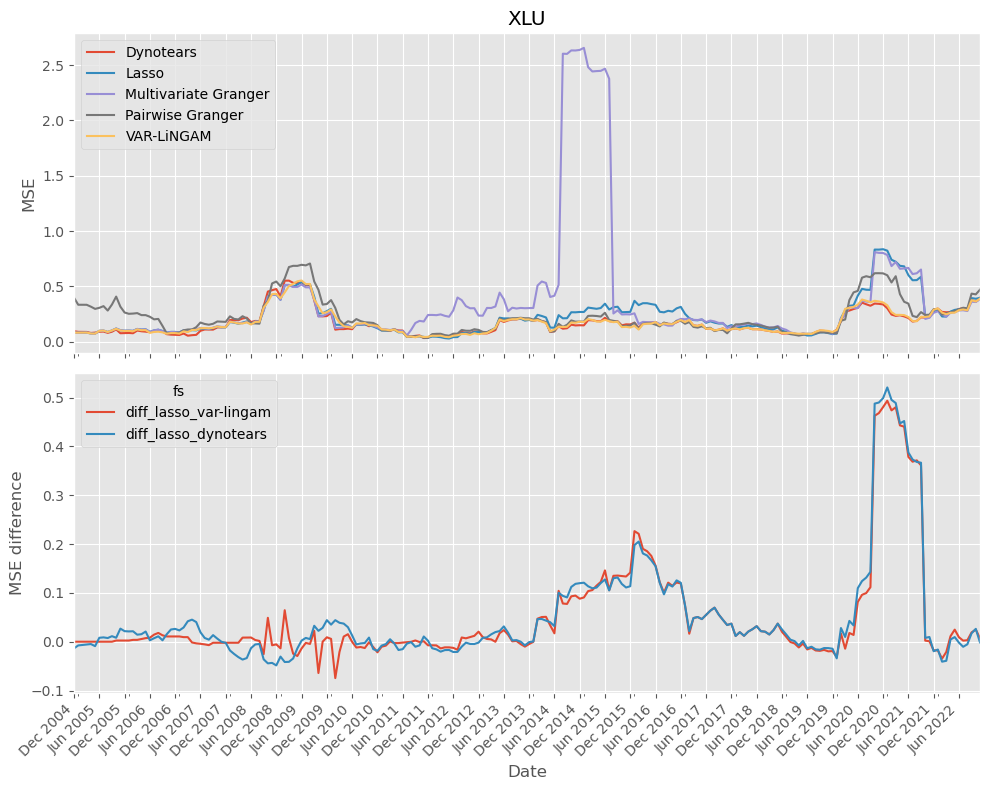

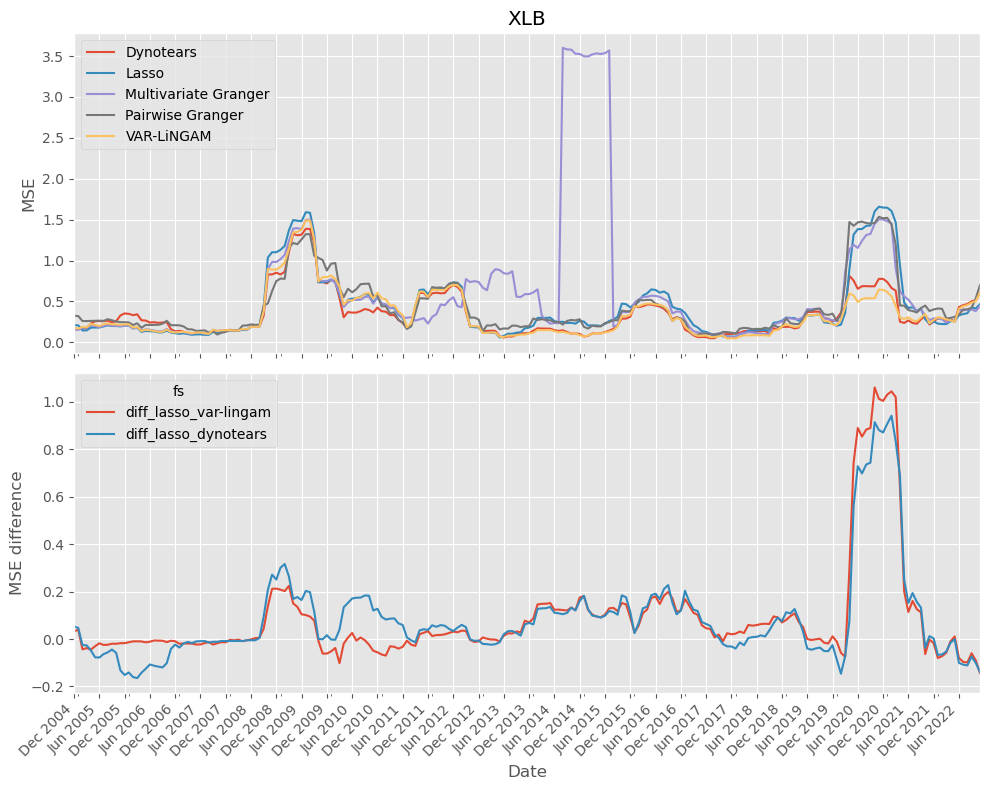

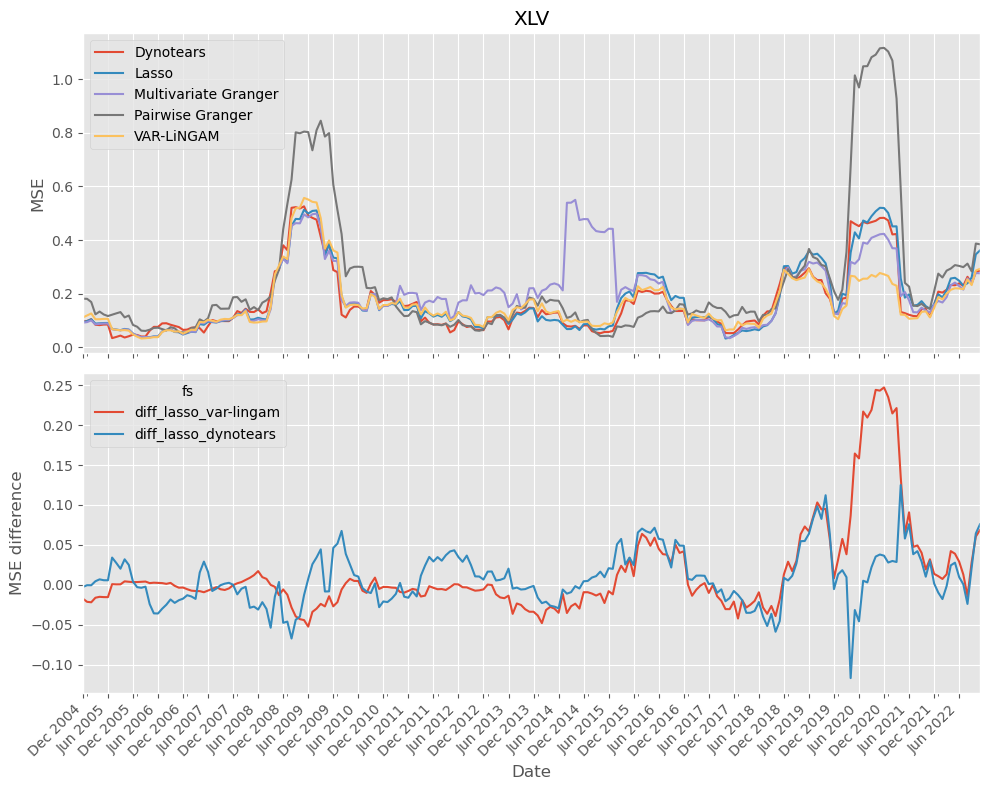

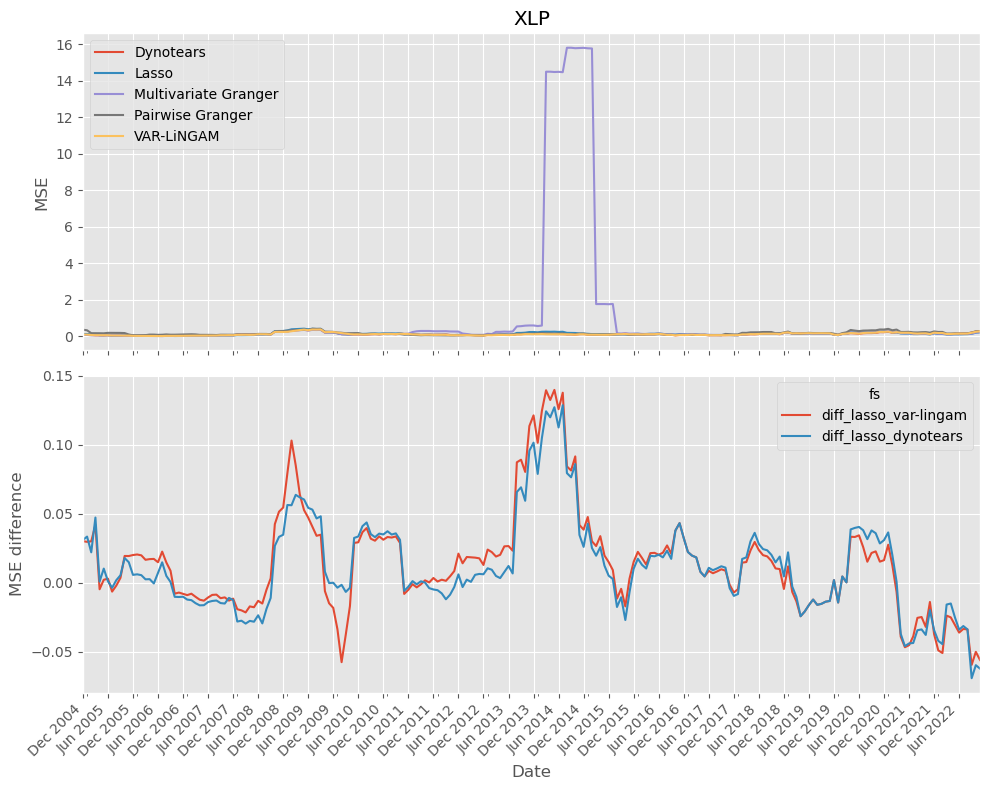

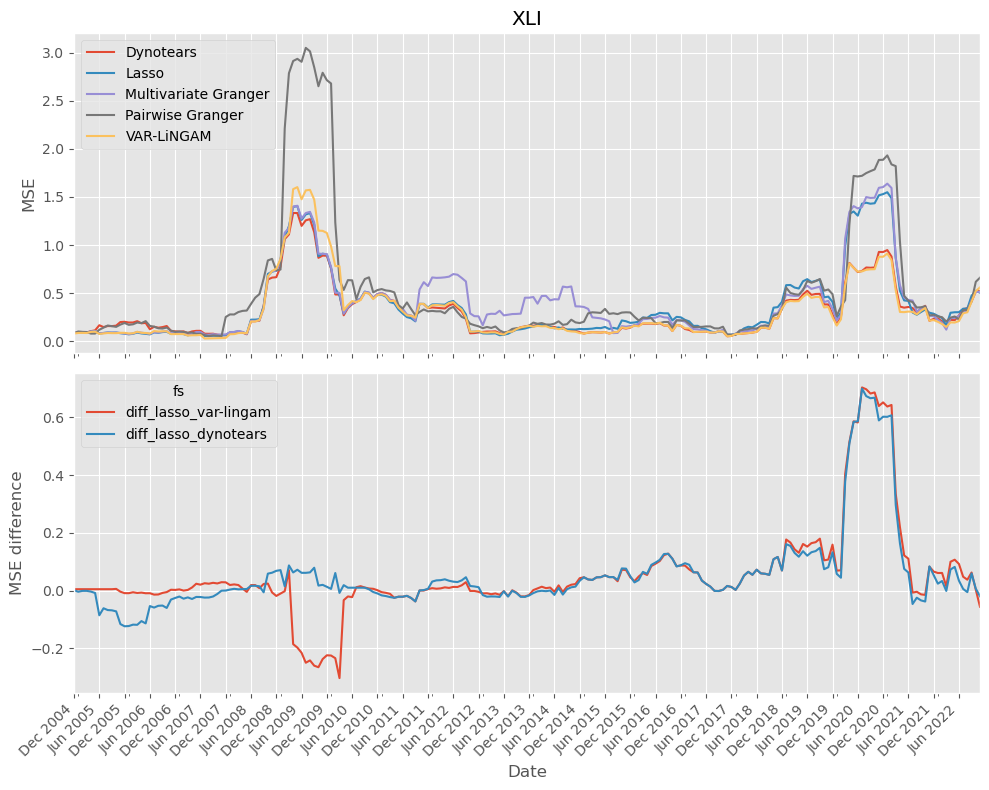

In [9]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df["diff_lasso_var-lingam"] = etf_rolling_metrics_df["Lasso"] - etf_rolling_metrics_df["VAR-LiNGAM"]
    etf_rolling_metrics_df["diff_lasso_dynotears"] = etf_rolling_metrics_df["Lasso"] - etf_rolling_metrics_df["Dynotears"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_lasso_var-lingam", "diff_lasso_dynotears"], axis=1).plot(ax=axs[0])
    # etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df[["diff_lasso_var-lingam", "diff_lasso_dynotears"]].plot(ax=axs[1])
    # etf_rolling_metrics_df[["diff_lasso_var-lingam"]].plot(ax=axs[1])
    # axs[1].set_title(f'MSE difference between lasso and a causal model for {etf}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_mse.png'))

    # Show the plot
    plt.show()

## Selected parents over time

In [10]:
etf = "SPY"
fss = ["VAR-LiNGAM", "Multivariate Granger"]

In [11]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[0]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

value                    
etf               SPY                    
fs         VAR-LiNGAM                    
cluster           0.0  1.0  2.0  3.0  4.0
date                                     
2020-01-31        NaN  NaN  1.0  NaN  NaN
2020-02-29        NaN  NaN  NaN  NaN  1.0
2020-03-31        NaN  NaN  1.0  NaN  NaN
2020-04-30        NaN  1.0  NaN  1.0  NaN

In [12]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[1]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

date


## Summary Statistics Sorted by MSE

In [13]:
all_metrics_df.sort_values(by=["mse"], ascending=True)

mse       mae  mse_crisis  mae_crisis  \
fs                   etf                                               
VAR-LiNGAM           XLP  0.121004  2.719495    0.137388    2.927141   
Dynotears            XLP  0.124097  2.780173    0.136860    2.941746   
Lasso                XLP  0.134633  2.830974    0.144788    3.037956   
Pairwise Granger     XLP  0.163637  3.054432    0.185310    3.294793   
VAR-LiNGAM           XLV  0.164190  3.172548    0.174297    3.381434   
Dynotears            XLV  0.168300  3.090107    0.253790    3.628212   
                     XLU  0.172661  3.202696    0.243356    4.067076   
VAR-LiNGAM           XLU  0.174784  3.335570    0.231107    3.836256   
Lasso                XLV  0.179847  3.227739    0.268740    3.886408   
Dynotears            SPY  0.189933  3.241779    0.271901    3.932859   
VAR-LiNGAM           SPY  0.194911  3.194146    0.264239    3.616083   
Multivariate Granger XLV  0.200191  3.405135    0.232258    3.751016   
Lasso                SPY  0.202239  3.351305    0.306520    4.189959   
                     XLU  0.220620  3.596855    0.436075    5.213957   
Pairwise Granger     XLU  0.234881  3.734417    0.331187    4.533956   
                     XLV  0.242763  3.704043    0.457802    4.815852   
VAR-LiNGAM           XLK  0.258626  3.977932    0.332692    4.592362   
Pairwise Granger     SPY  0.265559  3.699144    0.515905    4.887759   
Dynotears            XLK  0.278650  4.253828    0.384074    5.248894   
VAR-LiNGAM           XLY  0.283462  3.895656    0.334764    4.148982   
Dynotears            XLY  0.283854  3.823402    0.406200    4.364075   
                     XLI  0.307414  4.053267    0.383001    4.002550   
VAR-LiNGAM           XLI  0.313212  3.986272    0.370351    3.935606   
Multivariate Granger SPY  0.313317  3.776458    0.349560    4.230044   
Lasso                XLK  0.315494  4.428433    0.464224    5.289053   
                     XLY  0.334310  4.078617    0.674666    5.351502   
VAR-LiNGAM           XLB  0.342474  4.384429    0.370411    4.795098   
Dynotears            XLB  0.342730  4.406802    0.411001    4.897566   
Lasso                XLI  0.358000  4.306633    0.606857    5.198442   
Multivariate Granger XLU  0.358407  3.949290    0.401324    4.624512   
Pairwise Granger     XLK  0.365706  4.519058    0.738990    6.474502   
Multivariate Granger XLY  0.383375  4.419079    0.403013    4.414926   
Pairwise Granger     XLY  0.391272  4.372524    0.686970    5.463561   
Multivariate Granger XLI  0.401840  4.578564    0.620636    5.079398   
VAR-LiNGAM           XLF  0.413995  4.540302    0.516443    5.389534   
Lasso                XLB  0.422245  4.899378    0.734109    6.480414   
Pairwise Granger     XLB  0.439382  4.913992    0.681302    5.777138   
Dynotears            XLF  0.449396  4.721811    0.684867    6.071325   
Pairwise Granger     XLI  0.506684  4.963217    0.814845    6.092365   
Lasso                XLF  0.534614  5.015827    1.016083    6.933099   
Multivariate Granger XLB  0.608036  5.316780    0.676330    6.392652   
VAR-LiNGAM           XLE  0.635989  5.603940    1.487241    7.838075   
Dynotears            XLE  0.657820  5.746179    1.580698    8.233168   
Pairwise Granger     XLF  0.674872  5.538294    1.091742    7.753258   
Lasso                XLE  0.698907  5.969331    1.712214    8.663449   
Multivariate Granger XLF  0.707160  5.288839    0.811499    6.406463   
                     XLE  0.806247  6.411175    1.732561    8.697050   
Pairwise Granger     XLE  0.956422  6.405162    2.329636    9.450807   
Multivariate Granger XLP  0.979139  3.721513    0.152871    3.197584   
                     XLK  1.279741  5.367394    0.409804    4.929014   

                          stability  
fs                   etf             
VAR-LiNGAM           XLP   0.200000  
Dynotears            XLP   0.255914  
Lasso                XLP   5.544053  
Pairwise Granger     XLP  12.797235  
VAR-LiNGAM           XLV   0.232258  
Dynotears           

In [14]:
all_metrics_df.sort_values(by=["mse_crisis"], ascending=True)

,,mse,mae,mse_crisis,mae_crisis,stability
fs,etf,,,,,
Dynotears,XLP,0.124097,2.780173,0.136860,2.941746,0.255914
VAR-LiNGAM,XLP,0.121004,2.719495,0.137388,2.927141,0.200000
Lasso,XLP,0.134633,2.830974,0.144788,3.037956,5.544053
Multivariate Granger,XLP,0.979139,3.721513,0.152871,3.197584,25.773050
VAR-LiNGAM,XLV,0.164190,3.172548,0.174297,3.381434,0.232258
Pairwise Granger,XLP,0.163637,3.054432,0.185310,3.294793,12.797235
VAR-LiNGAM,XLU,0.174784,3.335570,0.231107,3.836256,0.224242
Multivariate Granger,XLV,0.200191,3.405135,0.232258,3.751016,24.333333
Dynotears,XLU,0.172661,3.202696,0.243356,4.067076,0.265185
